In [14]:
import tensorflow as tf 
import pandas as pd 
import json
# from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import numpy as np
import re
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from tensorflow.keras.utils import pad_sequences
import pickle
from sklearn.naive_bayes import GaussianNB
import matplotlib.pyplot as plt

In [2]:
# get the data

def first_data(): 
    num_class = 5
    questions = []
    classes = []
    with open("./content.json", encoding='utf-8') as f: 
        # load json file
        data = json.load(f)
        for type_class in range(num_class): 
            # get the question data
            questions.append(data['intents'][type_class]['input'])
            # iterate for label class
            for i in range(len(data['intents'][type_class]['input'])): 
                # get the class data
                classes.append(data['intents'][type_class]['tag']) 
    # return all question and classes
    return questions, classes 

def final_data(questionsm, tags):
    final_questions  = []
    for row in range(len(questionsm)):
        for column in range(len(questionsm[row])): 
            final_questions.append(questionsm[row][column])
    #  define dataframe
    df = pd.DataFrame()
    # change the previou questions to finalq questions value 
    df['question'] = final_questions
    #  change the previou tags to final tag value 
    df['tag'] = tags
    # return final dataframe
    return  df


def encode_label(df: pd.DataFrame, tags: pd.Series): 
    le = LabelEncoder()
    le.fit(np.unique(tags))
    df['tag'] = le.fit_transform(df['tag'])
    return df, le.classes_

def get_train_test_data(df: pd.DataFrame): 
    # drp the tag colunns
    feature = np.array(df.drop('tag', axis =1))
    target = np.array(df['tag'])

    # the test data will save as xlsx data
    X_train, y_train = np.array(feature), np.array(target)
    return  X_train, y_train

def text_preprocesing(text): 
    #  define stemmer from sastrawi 
    factory = StemmerFactory()
    # stemmer 
    stemmer = factory.create_stemmer()
    for row in range(len(text)): 
        for column in range(len(text[row])):
            text[row][column] = text[row][column].lower()
            # delete alfanumeric
            text[row][column] = re.sub(r'\W', ' ', text[row][column])
            # delete number
            text[row][column] = re.sub(r'\d+', '', text[row][column])
            # delete excessive whitespace
            text[row][column] = re.sub(r'\s+', ' ', text[row][column])
            text[row][column] = stemmer.stem(text[row][column])

    return text        
        

def create_model_and_train(x_train, y_train):
    # dofine callbacks
    class CustomCallbaks(tf.keras.callbacks.Callback): 
        def on_epoch_end(self, epoch, logs={}):
            if(logs.get('accuracy')>0.95):
                print("\nTrain was stopped")
                self.model.stop_training = True

    # trying tokenize 
    x_train_list = x_train.tolist()
    # define tokenizer
    tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words= 2000, oov_token= "<OOV>")
    tokenizer.fit_on_texts(x_train_list)

    x_train_sequence = tokenizer.texts_to_sequences(x_train_list)
    x_train_padded = pad_sequences(x_train_sequence)
    inputs = tf.keras.Input(shape=(None, ))
    x = tf.keras.layers.Embedding(1000, 2)(inputs)
    x = tf.keras.layers.LSTM(units = 200)(x)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(128, activation="relu")(x)
    predictions = tf.keras.layers.Dense(5, activation="softmax", name="predictions")(x)
    model = tf.keras.Model(inputs, predictions)
    model.compile(
        loss=tf.keras.losses.SparseCategoricalCrossentropy(),
        optimizer='adam',
        metrics=['accuracy']
    )

    history = model.fit(x_train_padded, y_train,epochs = 200, callbacks= CustomCallbaks())
    model.save("./bot_model.h5")
    return model, history, tokenizer

def predict_class(text: str, tokenizer, model): 
    factory = StemmerFactory()
    # stemmer 
    stemmer = factory.create_stemmer()
    text= text.lower()
    text= re.sub(r'\W', ' ', text)
    # delete number
    text= re.sub(r'\d+', '', text)
    # delete excessive whitespace
    text= re.sub(r'\s+', ' ', text)
    final_text= stemmer.stem(text)
    # final_text = text_preprocesing(text)
    print(final_text)
    text_tokeneize = tokenizer.texts_to_sequences([final_text])
    text_tokeneize = pad_sequences(text_tokeneize)
    pred = model.predict(text_tokeneize)
    return pred


In [3]:
questions, classes = first_data()
final =  final_data(questions,  classes)




In [4]:
final.head(10)

,question,tag
0,Hai,greeting
1,Halo,greeting
2,Hei,greeting
3,Assalamualaikum,greeting
4,Hi,greeting
5,Apa kabar,greeting
6,Yo,greeting
7,Wassup,greeting
8,Hey,greeting
9,Selamat datang,greeting


In [5]:
df_final, class_encode = encode_label(final, final['tag'])
df_final.head(20)

,question,tag
0,Hai,2
1,Halo,2
2,Hei,2
3,Assalamualaikum,2
4,Hi,2
5,Apa kabar,2
6,Yo,2
7,Wassup,2
8,Hey,2
9,Selamat datang,2


In [6]:
class_encode.shape

(5,)

In [7]:
class_encode

array(['general', 'goodbye', 'greeting', 'izin', 'sakit'], dtype=object)

In [8]:
X_train, y_train = get_train_test_data(df_final)
# the x train len is : 250

In [9]:
X_train = text_preprocesing(X_train)
# X_test = text_preprocesing(X_test)


In [10]:
model, history, tokenizer  = create_model_and_train(X_train, y_train)
# create_model_and_train(df=df_final)

Epoch 1/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.2276 - loss: 1.6100
Epoch 2/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1967 - loss: 1.6092 
Epoch 3/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.2477 - loss: 1.6086 
Epoch 4/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.2072 - loss: 1.6091 
Epoch 5/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.2199 - loss: 1.6082 
Epoch 6/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3255 - loss: 1.6063 
Epoch 7/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.2936 - loss: 1.6041 
Epoch 8/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3432 - loss: 1.5989 
Epoch 9/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3442 - loss: 1.5886 
Epoch 10/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3752 - loss: 1.5694 
Epoch 11/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3873 - loss: 1.5419 
Epoch 12/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3848 - loss

In [11]:
# save tokenizer
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [12]:
pred = predict_class("hai", tokenizer, model)
# class_encode[np.argmax(pred)]
np.argmax(pred)


hai


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


2

In [13]:
class_encode

array(['general', 'goodbye', 'greeting', 'izin', 'sakit'], dtype=object)

In [17]:
history.history

{'accuracy': [0.19599999487400055,
  0.20000000298023224,
  0.20000000298023224,
  0.20000000298023224,
  0.23600000143051147,
  0.2800000011920929,
  0.2919999957084656,
  0.3240000009536743,
  0.3240000009536743,
  0.3240000009536743,
  0.3479999899864197,
  0.3880000114440918,
  0.3799999952316284,
  0.3880000114440918,
  0.4000000059604645,
  0.4000000059604645,
  0.3919999897480011,
  0.5680000185966492,
  0.6039999723434448,
  0.6159999966621399,
  0.5920000076293945,
  0.5960000157356262,
  0.5920000076293945,
  0.7039999961853027,
  0.6679999828338623,
  0.7639999985694885,
  0.7519999742507935,
  0.7879999876022339,
  0.8040000200271606,
  0.8240000009536743,
  0.843999981880188,
  0.8519999980926514,
  0.8399999737739563,
  0.9079999923706055,
  0.9200000166893005,
  0.9520000219345093],
 'loss': [1.61039400100708,
  1.6094563007354736,
  1.6093089580535889,
  1.6090972423553467,
  1.6079585552215576,
  1.606357216835022,
  1.6035048961639404,
  1.5981589555740356,
  1.588297

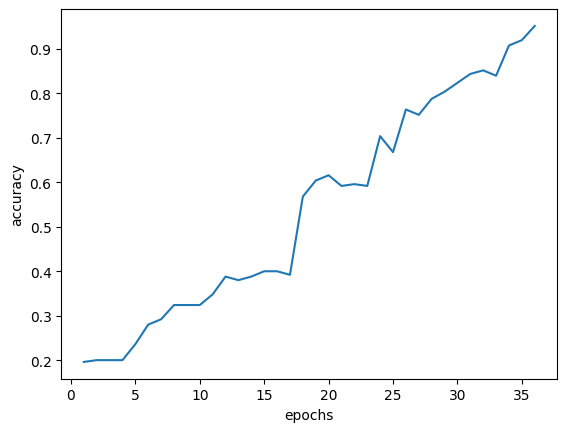

In [21]:
plt.plot([x for x in range(1, 37)], history.history['accuracy'])
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.savefig("accuracy_info.png")